In [1]:
#Load csv file
import os
import csv
import pandas as pd

os.chdir('C:/Negar/DSM_Sweden')  # Change to your working directory
file_path = 'output/national_soildata_with_time_covariates2.csv'
soildata_covariates = pd.read_csv(file_path)

In [2]:
# Define the exact covariate names you want in X
covariate_names = [
    "dfme_edtm", "geomorphon_edtm", "hillshade_edtm", "ls.factor_edtm", 
    "maxic_edtm", "minic_edtm", "neg.openness_edtm", "pos.openness_edtm", 
    "pro.curv_edtm", "shpindx_edtm", "slope.in.degree_edtm", "twi_edtm",
    "BSF_Yearly", "NDVI_Yearly", "NIR_Yearly", "NDWI_Yearly", "NDTI_Yearly",
    "Red_Yearly", "SWIR2_Yearly", "SWIR1_Yearly", "Green_Yearly", "Blue_Yearly",
    "CHELSA_Monthly_Precip", "ERA5_Monthly_Temp", "EVI_Bimonthly", 
    "NDSI_Bimonthly", "SAVI_Bimonthly", "bergart_rock_type","litotektonisk_enhet",
    #"crop_type","CDR_Yearly"
]

# Filter the DataFrame
X = soildata_covariates[covariate_names]

# Define Y
Y = soildata_covariates["Org mtrl (% ts)"]


In [3]:
# Convert Y to numeric, handling commas and stripping whitespace
Y = (
    Y.astype(str)
    .str.strip()
    .str.replace(',', '.')
)
Y = pd.to_numeric(Y, errors='coerce')
print(Y.dtype)

# Remove Y values more than 20
#Y = Y[Y <= 20] 
#changing the Y values to be between 0 and 20, the accuracy decrease 20 % for NN and about 8 % for RF, so we ignore it for now.

float64


In [4]:
# Combine X and Y into one DataFrame
data_clean = pd.concat([X, Y], axis=1)

# Drop rows with any NaN
data_clean = data_clean.dropna()

# Now split them back into X_clean and Y_clean
X_clean = data_clean[covariate_names]
Y_clean = data_clean["Org mtrl (% ts)"]

# Check again
print("Shape of X_clean:", X_clean.shape)
print("Shape of Y_clean:", Y_clean.shape)


Shape of X_clean: (12595, 29)
Shape of Y_clean: (12595,)


In [5]:
print("Number of NaNs in Y_clean:", Y_clean.isna().sum())
# Drop NaNs in Y_clean
Y_clean = Y_clean.dropna()
print("Shape of Y_clean after dropping NaNs:", Y_clean.shape)
# Ensure X_clean is aligned with Y_clean after dropping NaNs
X_clean = X_clean.loc[Y_clean.index]
print("Shape of X_clean after aligning with Y_clean:", X_clean.shape)
# shape are not equal
print("Final shape of X_clean:", X_clean.shape)
print("Final shape of Y_clean:", Y_clean.shape)


Number of NaNs in Y_clean: 0
Shape of Y_clean after dropping NaNs: (12595,)
Shape of X_clean after aligning with Y_clean: (12595, 29)
Final shape of X_clean: (12595, 29)
Final shape of Y_clean: (12595,)


In [6]:
OC_stats = Y_clean.describe()
print("Descriptive statistics for Organic Carbon (% ts):")
print(OC_stats)

Descriptive statistics for Organic Carbon (% ts):
count    12595.000000
mean         6.425026
std          9.109453
min          0.700000
25%          3.000000
50%          4.100000
75%          5.800000
max         74.700000
Name: Org mtrl (% ts), dtype: float64


In [6]:
# Descriptive statistics for selected soil properties
soil_properties = ['Sand 2-0,06 mm (% av mineraljord ts)', 'Ler <0,002 mm (% av mineraljord ts)', 'Silt 0,06-0,002 mm (% av mineraljord ts)', 'pH H2O']

# Check which columns are present in the DataFrame
available_props = [col for col in soil_properties if col in soildata_covariates.columns]

# Compute descriptive statistics
desc_stats = soildata_covariates[available_props].describe()
print(desc_stats)

       Sand 2-0,06 mm (% av mineraljord ts)  \
count                          12304.000000   
mean                              37.782185   
std                               24.423753   
min                                0.000000   
25%                               14.000000   
50%                               37.000000   
75%                               58.000000   
max                               95.000000   

       Ler <0,002 mm (% av mineraljord ts)  \
count                         12304.000000   
mean                             22.010809   
std                              14.888323   
min                               1.000000   
25%                              10.000000   
50%                              18.000000   
75%                              32.000000   
max                              74.000000   

       Silt 0,06-0,002 mm (% av mineraljord ts)        pH H2O  
count                              12304.000000  12598.000000  
mean                             

## Neural Network


In [6]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Step 1: Split
X_train, X_test, y_train, y_test = train_test_split(X_clean, Y_clean, test_size=0.2, random_state=42)

# Step 2: Scale only using training data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


from sklearn.neural_network import MLPRegressor

mlp = MLPRegressor(
    hidden_layer_sizes=(128, 64, 32),
    activation='relu',
    solver='adam', 
    alpha=0.001,
    learning_rate_init=0.001,
    max_iter=1000,
    early_stopping=True,
    random_state=42
)

mlp.fit(X_train_scaled, y_train)
y_pred = mlp.predict(X_test_scaled)

from sklearn.metrics import r2_score, mean_squared_error
print("R²:", r2_score(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("MSE:", mean_squared_error(y_test, y_pred))

#calculate the CCC score
from scipy.stats import pearsonr
def concordance_correlation_coefficient(y_true, y_pred):
    """Calculate the Concordance Correlation Coefficient (CCC)."""
    mean_true = np.mean(y_true)
    mean_pred = np.mean(y_pred)
    
    covariance = np.mean((y_true - mean_true) * (y_pred - mean_pred))
    variance_true = np.var(y_true)
    variance_pred = np.var(y_pred)
    
    ccc = (2 * covariance) / (variance_true + variance_pred + (mean_true - mean_pred) ** 2)
    return ccc

ccc_score = concordance_correlation_coefficient(y_test, y_pred)
print("Concordance Correlation Coefficient (CCC):", ccc_score)



R²: 0.4114567324259857
RMSE: 7.139998999163705
MSE: 50.979585708058714
Concordance Correlation Coefficient (CCC): 0.5761962192317671


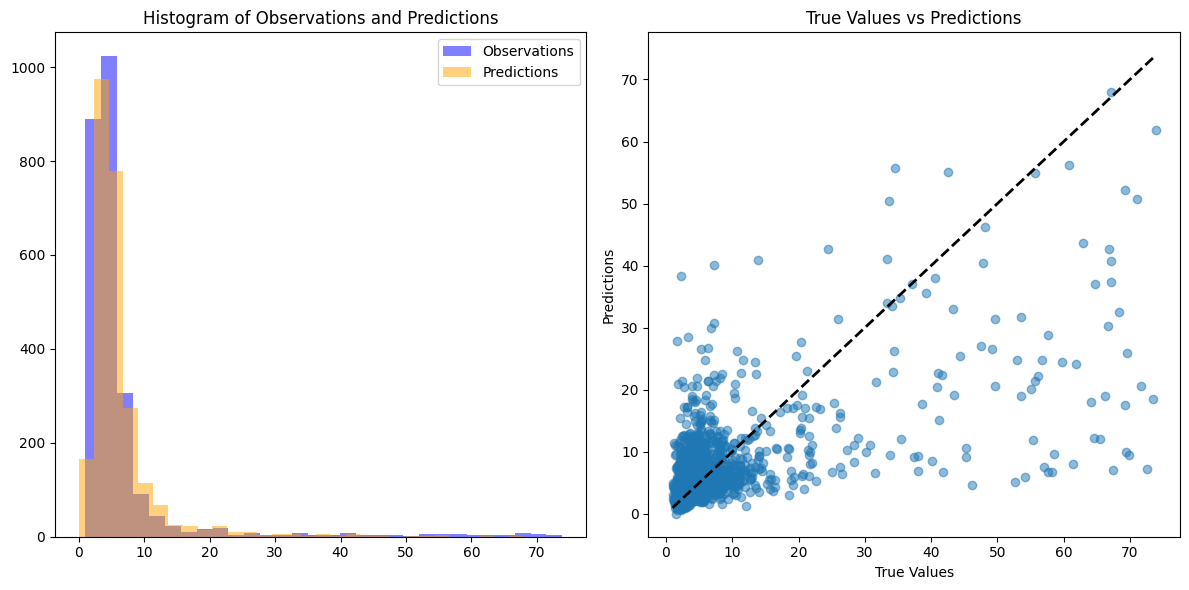

In [8]:
# check the histogram distribution of observations and predictions
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(y_test, bins=30, alpha=0.5, label='Observations', color='blue')
plt.hist(y_pred, bins=30, alpha=0.5, label='Predictions', color='orange')
plt.title('Histogram of Observations and Predictions')
plt.legend()
plt.subplot(1, 2, 2)
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('True Values vs Predictions')
plt.tight_layout()
plt.show()

### NN Permutation Importance

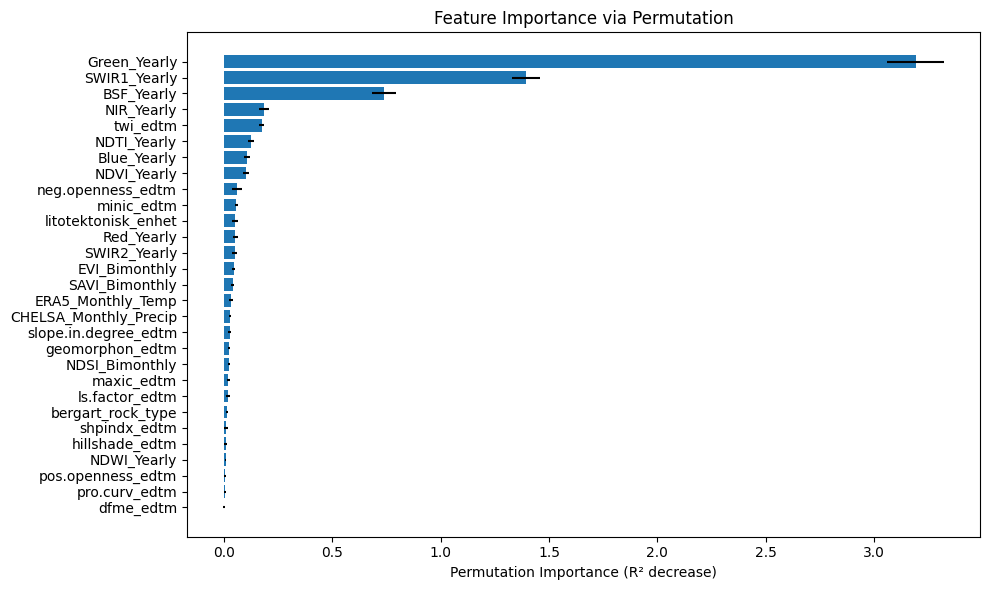

In [9]:
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Make sure to use scaled data and fitted model
# Run this *after* training your model
result = permutation_importance(
    mlp,            # Or use mlp, xgb_model, etc.
    X_test_scaled,       # Scaled test features
    y_test,              # True test labels
    n_repeats=10,        # Number of times to permute each feature
    random_state=42,
    scoring='r2'         # Or 'neg_mean_squared_error' if you prefer RMSE
)

# Convert results to DataFrame for easier plotting
importance_df = pd.DataFrame({
    'Feature': X_clean.columns,
    'Importance Mean': result.importances_mean,
    'Importance Std': result.importances_std
}).sort_values(by='Importance Mean', ascending=False)

# Plot
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance Mean'], xerr=importance_df['Importance Std'])
plt.gca().invert_yaxis()
plt.xlabel("Permutation Importance (R² decrease)")
plt.title("Feature Importance via Permutation")
plt.tight_layout()
plt.show()


In [27]:
from sklearn.model_selection import cross_val_score

# Store baseline score with all features
baseline_score = cross_val_score(
    mlp, X_train_scaled, y_train, cv=5, scoring='r2', n_jobs=-1
).mean()

print(f"Baseline CV R² with all features: {baseline_score:.4f}")

feature_scores = []
for i, col in enumerate(covariate_names):
    # Remove one feature at a time
    X_train_drop = np.delete(X_train_scaled, i, axis=1)
    # Cross-validate
    score = cross_val_score(
        mlp, X_train_drop, y_train, cv=5, scoring='r2', n_jobs=-1
    ).mean()
    feature_scores.append((col, score))

# Find features whose removal increases performance
improved = [(col, score) for col, score in feature_scores if score > baseline_score]

if improved:
    print("Removing these features increases CV R²:")
    for col, score in improved:
        print(f"{col}: CV R² = {score:.4f} (improved by {score - baseline_score:.4f})")
else:
    print("No single feature removal improved the CV R².")

Baseline CV R² with all features: 0.3377
Removing these features increases CV R²:
geomorphon_edtm: CV R² = 0.3385 (improved by 0.0007)
hillshade_edtm: CV R² = 0.3458 (improved by 0.0080)
neg.openness_edtm: CV R² = 0.3542 (improved by 0.0165)
pos.openness_edtm: CV R² = 0.3398 (improved by 0.0021)
pro.curv_edtm: CV R² = 0.3394 (improved by 0.0017)
Blue_Yearly: CV R² = 0.3397 (improved by 0.0020)


## Random Forest

In [10]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import r2_score, mean_squared_error

# Assuming X_clean and Y_clean are already defined and aligned.

# -------------------------------
# 1. Split the data into train/test
# -------------------------------
X_train, X_test, y_train, y_test = train_test_split(
X_clean, Y_clean, test_size=0.3, random_state=42
)

print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

# -------------------------------
# 2. Define the Random Forest model
# -------------------------------
rf_model = RandomForestRegressor(
    n_estimators=100,    # number of trees
    max_depth=None,      # can set max_depth if overfitting
    random_state=42,     # reproducibility
    n_jobs=-1            # use all cores
)

# -------------------------------
# 3. Fit the model to the training set
# -------------------------------
rf_model.fit(X_train, y_train)

# -------------------------------
# 4. Predict and evaluate on the test set
# -------------------------------
y_pred = rf_model.predict(X_test)

r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"Test R² Score: {r2:.4f}")
print(f"Test RMSE: {rmse:.4f}")

# -------------------------------
# 5. Perform 5-fold cross-validation
# -------------------------------
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(rf_model, X_clean, Y_clean, cv=kf, scoring='r2', n_jobs=-1)

print(f"5-Fold CV R² Scores: {cv_scores}")
print(f"Mean CV R² Score: {np.mean(cv_scores):.4f}")
print(f"Standard Deviation of CV R²: {np.std(cv_scores):.4f}")


Training set size: 8816
Test set size: 3779
Test R² Score: 0.2859
Test RMSE: 7.7995
5-Fold CV R² Scores: [0.32001164 0.29433389 0.28600544 0.26817504 0.29165179]
Mean CV R² Score: 0.2920
Standard Deviation of CV R²: 0.0167


### RF Feature Selection

Feature Importances:
                  Feature  Importance
25         NDSI_Bimonthly    0.181885
11               twi_edtm    0.088074
16            NDTI_Yearly    0.053571
10   slope.in.degree_edtm    0.046390
19           SWIR1_Yearly    0.043899
22  CHELSA_Monthly_Precip    0.043617
20           Green_Yearly    0.043266
21            Blue_Yearly    0.037792
2          hillshade_edtm    0.036121
12             BSF_Yearly    0.034739
23      ERA5_Monthly_Temp    0.033513
8           pro.curv_edtm    0.033482
15            NDWI_Yearly    0.032079
13            NDVI_Yearly    0.031598
18           SWIR2_Yearly    0.027659
17             Red_Yearly    0.025602
3          ls.factor_edtm    0.024766
14             NIR_Yearly    0.024468
5              minic_edtm    0.022394
4              maxic_edtm    0.022364
9            shpindx_edtm    0.021319
0               dfme_edtm    0.019702
24          EVI_Bimonthly    0.017575
26         SAVI_Bimonthly    0.015823
6       neg.openness_edtm    

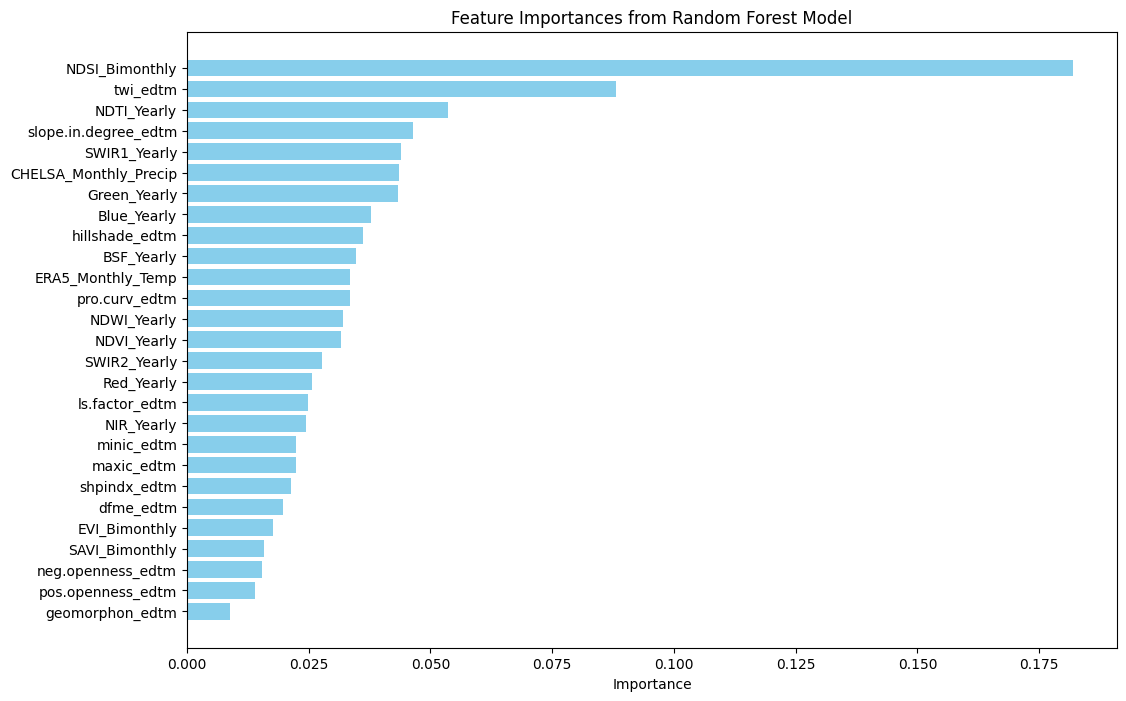

Test R² Score with Top Features: 0.2936
Test RMSE with Top Features: 7.7868


In [32]:
# let's run the rf again with feature importance
# Get feature importances from the Random Forest model
importances = rf_model.feature_importances_
# Create a DataFrame for feature importances
feature_importances = pd.DataFrame({
    'Feature': X_clean.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)
# Print the feature importances
print("Feature Importances:")
print(feature_importances)
# Plotting feature importances
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 8))
plt.barh(feature_importances['Feature'], feature_importances['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.title('Feature Importances from Random Forest Model')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature on top
plt.show()

#now train a model with the most important features
# Select the top 15 most important features
top_n = 15
top_features = feature_importances.head(top_n)['Feature'].tolist()
# Filter X_clean to only include the top features
X_top = X_clean[top_features]
# Split the data into train/test again with the top features
X_train_top, X_test_top, y_train_top, y_test_top = train_test_split(
    X_top, Y_clean, test_size=0.4, random_state=42
)
# Define a new Random Forest model
rf_model_top = RandomForestRegressor(
    n_estimators=100,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)
# Fit the model to the training set with top features
rf_model_top.fit(X_train_top, y_train_top)
# Predict and evaluate on the test set with top features
y_pred_top = rf_model_top.predict(X_test_top)
r2_top = r2_score(y_test_top, y_pred_top)
rmse_top = np.sqrt(mean_squared_error(y_test_top, y_pred_top))
print(f"Test R² Score with Top Features: {r2_top:.4f}")
print(f"Test RMSE with Top Features: {rmse_top:.4f}")


## Ensemble ML with tested mlp


In [52]:
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

mlp_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('mlp', MLPRegressor(
        hidden_layer_sizes=(128, 64, 32),
        activation='relu',
        solver='adam',
        alpha=0.001,
        learning_rate_init=0.001,
        max_iter=1000,
        early_stopping=True,
        random_state=42
    ))
])


In [53]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

# Define base learners including your tuned MLP with scaler
base_learners = [
    ('lr', LinearRegression()),
    ('rf', RandomForestRegressor(n_estimators=100, random_state=42)),
    ('svr', SVR(kernel='rbf')),
    ('xgb', XGBRegressor(objective='reg:squarederror', random_state=42)),
    ('mlp_scaled', mlp_pipeline)  # your best MLP model with scaling
]

# Define meta-learner
meta_learner = LinearRegression()

# Define stacking model
stack_model = StackingRegressor(
    estimators=base_learners,
    final_estimator=meta_learner,
    cv=5,
    passthrough=True,
    n_jobs=-1
)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_clean, Y_clean, test_size=0.2, random_state=42)

# Fit and evaluate
stack_model.fit(X_train, y_train)
y_pred = stack_model.predict(X_test)

r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"Stacked Model with Scaled MLP - R² Score: {r2:.4f}, RMSE: {rmse:.4f}")


Stacked Model with Scaled MLP - R² Score: 0.4155, RMSE: 7.1155


As we see, the difference between MLP and Ensemble is not much. so we continue with MLP. Now we can try only kriging method or combine kriging with MLP.